In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import os
from matplotlib import pyplot


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

torch.manual_seed(42)

## Downloading the data

In [2]:
data_path = '/CV_projects/cifar10/exampledata'
cifar10 = datasets.CIFAR10( data_path, train=True, download=True,
         transform=transforms.Compose([
           transforms.Resize((227,227)),
           transforms.ToTensor(),
           transforms.RandomHorizontalFlip(p=0.7),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                              ]
        )) 

Files already downloaded and verified


In [3]:
cifar10_test=datasets.CIFAR10(data_path, train=False, download=True,
           transform=transforms.Compose([
               transforms.Resize((227,227)),
               transforms.ToTensor(),
               transforms.RandomHorizontalFlip(p=0.7),
               transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
           ]))

Files already downloaded and verified


## Train Validation set split

In [4]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(cifar10, test_size=0.2)

In [5]:
print(f"Train data: {len(train_list)}")
print(f"valid data: {len(val_list)}")
print (f"Test data: {len(cifar10_test)}")


Train data: 40000
valid data: 10000
Test data: 10000


In [6]:
classes = ('plane', 'car','bird','cat','dear','dog','frog','horse','ship','truck')

## DataLoaders

In [7]:
trainloader= torch.utils.data.DataLoader(train_list, batch_size=32, shuffle=True)
print(len(trainloader))
validloader= torch.utils.data.DataLoader(val_list, batch_size=32, shuffle=False)
print(len(validloader))
testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=32, shuffle = False)
print(len(testloader))

1250
313
313


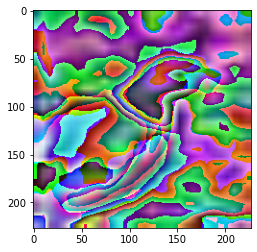

In [8]:
#commentout the normalization in cifar10 train data to see unnormalized img
img = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(img))


## Train visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 227, 227])


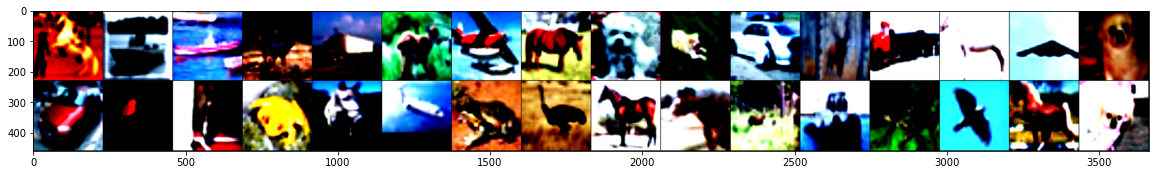

In [9]:
from torchvision.utils import make_grid
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Validation set visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 227, 227])


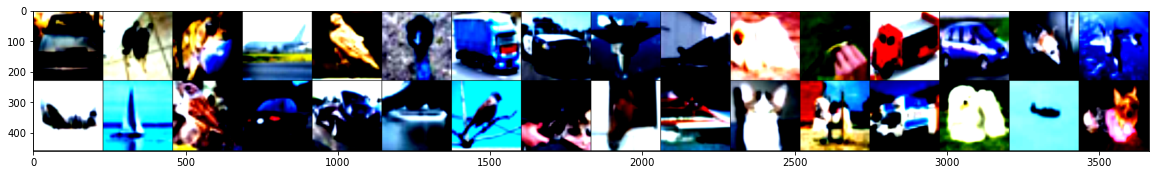

In [10]:
for images, _ in validloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Testset visualization


images.shape: torch.Size([32, 3, 227, 227])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


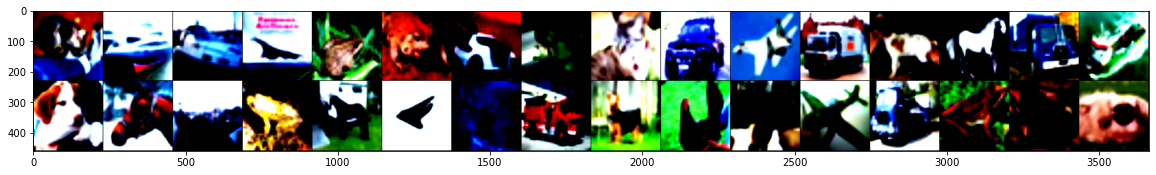

In [11]:
for images, _ in testloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [12]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


## Training Loop

In [13]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader ):
     for epoch in range(1, epoch+1):
         epoch_loss = 0
         for data, label in trainloader:
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss +=loss.item()
            
         if epoch == 1 or epoch %10 == 0:
            print(f"Loss in epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()}")
    
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  data = data.to(device=device)
                  label = label.to(device=device)
            ## Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, predicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((predicted == label).sum())
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")

## Transfer learning Resnet50

In [24]:
from torchvision.models import resnet50
model1 = resnet50(pretrained = True)

# Modifying Head of the classifier

model1.fc = nn.Sequential(
    nn.Dropout(0.3), #dropout incoming last convnet's few features
    nn.Linear(2048, 10)
)

In [25]:
model = resnet50().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
loss_fn = nn.CrossEntropyLoss()


In [27]:

 
TrainingLoop(
      epoch = 10,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      trainloader = trainloader,
 )



Loss in epoch 1 : 1.4224882191181183 : date and time : 2022-04-20 16:26:26.496767
Loss in Valid epoch 1 : 1.1920045176253151 : Got 5673 / 10000 with valid accuracy of :56.73
Loss in epoch 10 : 0.24873403111994266 : date and time : 2022-04-20 17:35:34.626481
Loss in Valid epoch 10 : 0.577941229644294 : Got 8176 / 10000 with valid accuracy of :81.76


In [28]:
torch.save(model.state_dict(), "resnet50_cifar10.pt") #save the model

In [29]:
model = resnet50()
model.load_state_dict(torch.load("/CV_projects/cifar10/resnet50_cifar10.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:

total = 0
correct = 0

with torch.no_grad():
    for imgs, labels in testloader:
                imgs = imgs.to(device="cpu")
                labels = labels.to(device="cpu")
                output = model(imgs)
                _, predicted = torch.max(output, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
    print(
              f"Got {correct} / {total} with test accuracy {float(correct) / float(total) * 100:.2f}"
)


Got 8230 / 10000 with test accuracy 82.30
